# Playing with rank computation

In [1]:
from scipy.sparse import save_npz, load_npz, rand, coo_matrix
import numpy as np
import tensorflow as tf
from parallelrank import find_rank

# assert len(tf.config.list_physical_devices('GPU')) > 0

### Simple comparison

In [7]:
matrix = rand(1000, 1000, density=0.0001, format='csr', dtype=np.int8)

In [ ]:
%%time
rank = tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
print(rank)

In [ ]:
%%time
rank = find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
print(rank)

### Generate dataset to compare algorithms

In [2]:
def create_density(side, density_side):
    return (density_side / side)

In [3]:
sides = [100, 500, 1000, 5000, 10_000, 50_000]
density_side = 10
repititions = 10

In [4]:
def pseudo_random_sparce(m, n, density=0.01, format='coo'):
    tp = np.intc
    k = int(round(density * m * n))

    ind = np.random.choice(m * n, size=k, replace=True)

    j = np.floor(ind * 1. / m).astype(tp, copy=False)
    i = (ind - j * m).astype(tp, copy=False)

    return coo_matrix((np.ones(k), (i, j)), shape=(m, n)).asformat(format,
                                                             copy=False)

In [ ]:
# Skip this part if dataset is already generated
for side in sides:
    for i in range(repititions):
        density = create_density(side, density_side)
        if side > 10_000:
            matrix = pseudo_random_sparce(side, side, density, 'csr')
        else:
            matrix = rand(side, side, density=density, format='csr', dtype=np.int8)
        matrix.data[:] = 1
        save_npz("data/side_{}/matrix_{}.npz".format(side, i), matrix)

### Execure different algorithms on the generated dataset

In [5]:
from time import perf_counter

def test_algorithm(sides, repititions, algorithm_func, time_limit=60*60):
    algorithm_time = []
    stop_computation = False

    for side in sides:
        if stop_computation:
            break
        
        print("Computing rank for matrices {}x{}".format(side, side))
        total_time = 0
        successful_repititions = 0
        
        for i in range(repititions):
            print("  Attempt", i+1)
            matrix = load_npz("data/side_{}/matrix_{}.npz".format(side, i))
            
            time_start = perf_counter()
            rank = algorithm_func(matrix)
            time_stop = perf_counter()
            time_spent = time_stop-time_start
            
            total_time += time_spent
            successful_repititions += 1
            print("  Computation time", time_spent)
            print("  Rank ", rank)
            if time_spent > time_limit:
                stop_computation = True
                break
            
        algorithm_time.append(total_time / successful_repititions)

    return np.array(algorithm_time)

In [5]:
algorithm_time = test_algorithm(
    sides[:-1], 
    1, 
    lambda matrix: find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
)
#np.save("data/algorithm_time_v0.3.npy", algorithm_time)

Computing rank for matrices 100x100
  Attempt 1
  Computation time 2.593298279999999
  Rank  100
Computing rank for matrices 500x500
  Attempt 1
  Computation time 4.104586608999995
  Rank  498
Computing rank for matrices 1000x1000
  Attempt 1
  Computation time 9.155929784000023
  Rank  1000
Computing rank for matrices 5000x5000
  Attempt 1
  Computation time 68.31934908599999
  Rank  4999
Computing rank for matrices 10000x10000
  Attempt 1
  Computation time 329.104301191
  Rank  9998


In [ ]:
tf_time = test_algorithm(
    sides[:-1], 
    1, 
    lambda matrix: tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
)
np.save("data/tf_time.npy", tf_time)

### Compare computation time

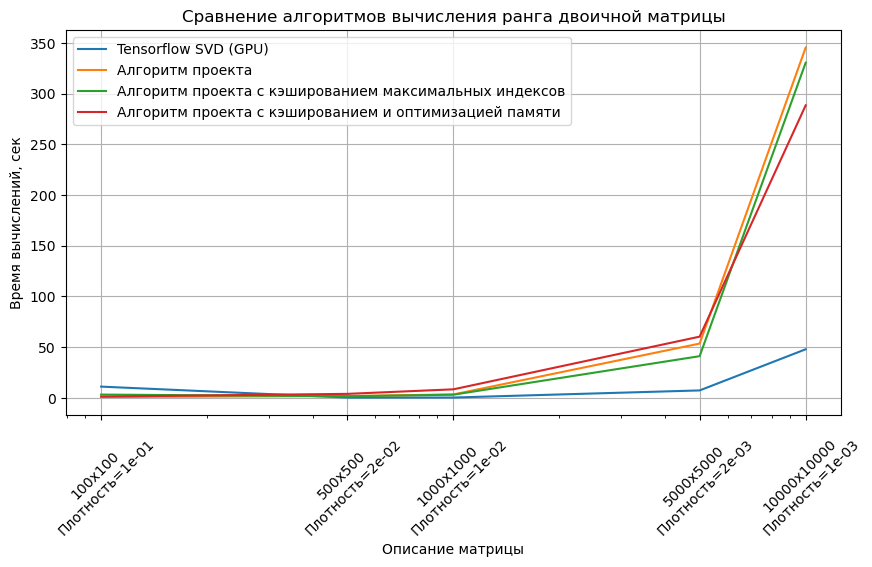

In [21]:
from matplotlib import pyplot as plt

used_sides = sides[:-1]

fig = plt.figure(figsize=(10, 5))
plt.plot(used_sides, np.load("data/tf_time.npy"), label="Tensorflow SVD (GPU)")
plt.plot(used_sides, "data/cpualgorithm_time.npy", label="Алгоритм Гаусса")
plt.plot(used_sides, np.load("data/algorithm_time_v0.1.npy"), label="Алгоритм проекта")
plt.plot(used_sides, np.load("data/algorithm_time_v0.2.npy"), label="Алгоритм проекта с кэшированием максимальных индексов")
plt.plot(used_sides, np.load("data/algorithm_time_v0.3.npy"), label="Алгоритм проекта с кэшированием и оптимизацией памяти")
plt.xscale('log')
plt.xticks(
    used_sides, 
    list(map(lambda x: "{}x{}\nПлотность={:.0e}".format(
        str(x), 
        str(x), 
        create_density(x, density_side)
    ), used_sides)), 
    rotation=45
)
plt.title("Сравнение алгоритмов вычисления ранга двоичной матрицы")
plt.legend()
plt.xlabel("Описание матрицы")
plt.ylabel("Время вычислений, сек")
plt.grid()
plt.show()

### Memory consumption

In [ ]:
# Use it with LOG_MEMORY_CONSUMPTION preprocessor definition
matrix = load_npz("data/side_10000/matrix_3.npz")
            
find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])

In [19]:
capacities = []
sizes = []

with open("data/algorithm_memory_v0.3_10000.txt") as logs:
    string_start = "row_inds size: "
    mem_cons_string_start = "Memory consumption (int32_t's): c_off: 10001 c_sizes: 10000 max_rows: 10000 row_inds: "
    
    i = 0
    for line in logs.readlines():
        if i % 2 == 1:
            size = int(line[len(string_start):])
            sizes.append(size)
        else:
            capacity = int(line[len(mem_cons_string_start):])
            capacities.append(capacity)
            
        i += 1
        
capacities = np.array(capacities)
sizes = np.array(sizes)
np.save("data/algorithm_memory_nnz_size_v0.3_10000.npy", sizes)
np.save("data/algorithm_memory_nnz_cap_v0.3_10000.npy", capacities)

In [14]:
sizes = np.load("data/algorithm_memory_nnz_size_v0.3_10000.npy")
capacities = np.load("data/algorithm_memory_nnz_cap_v0.3_10000.npy")
# Add c_off, c_sizes, max_rows
capacities += 10001 + 10000 + 10000
# Squashing period is 64

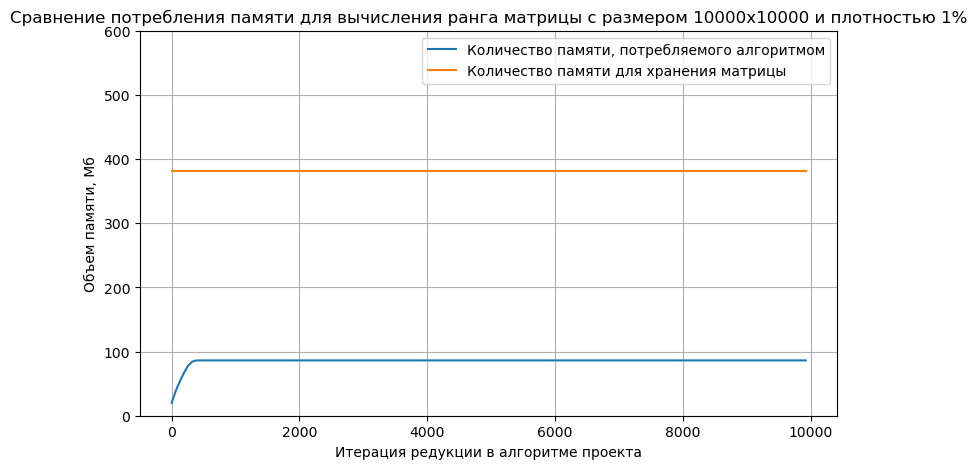

In [37]:
# Матрица размера 10000x10000 и с плотностью 1%

attempts = np.arange(len(capacities)) * 64

fig = plt.figure(figsize=(9, 5))
#plt.plot(attempts, sizes)
plt.plot(attempts, capacities * 4 / 1024 / 1024, label = "Количество памяти, потребляемого алгоритмом")
plt.plot(attempts, [(10000*10000*4) / 1024 / 1024] * len(attempts), label = "Количество памяти для хранения матрицы")

plt.title("Сравнение потребления памяти для вычисления ранга матрицы c размером 10000x10000 и плотностью 1%")
plt.legend()
plt.xlabel("Итерация редукции в алгоритме проекта")
plt.ylabel("Объем памяти, Мб")
#plt.yscale('log')
plt.ylim(0, 600)
plt.grid()
plt.show()

### Homology dataset

In [2]:
matrix = rand(100, 100, density=1e-3, format='csr', dtype=np.int8)
for i in range(4):
    find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])

In [4]:
from time import perf_counter

cpu_time = []
cpu_mem = []
gpu_time = []
gpu_mem = []

for i in range(4):
    matrix = load_npz("data/homology/PathGraph{}.npz".format(i))
    
    time_start = perf_counter()
    rank, mem = find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0], algorithm='hom', log_memory=True)
    time_stop = perf_counter()
    gpu_time.append(time_stop-time_start)
    gpu_mem.append(mem)
    
    time_start = perf_counter()
    rank, mem = find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0], algorithm='gauss', log_memory=True)
    time_stop = perf_counter()
    cpu_time.append(time_stop-time_start)
    cpu_mem.append(mem)

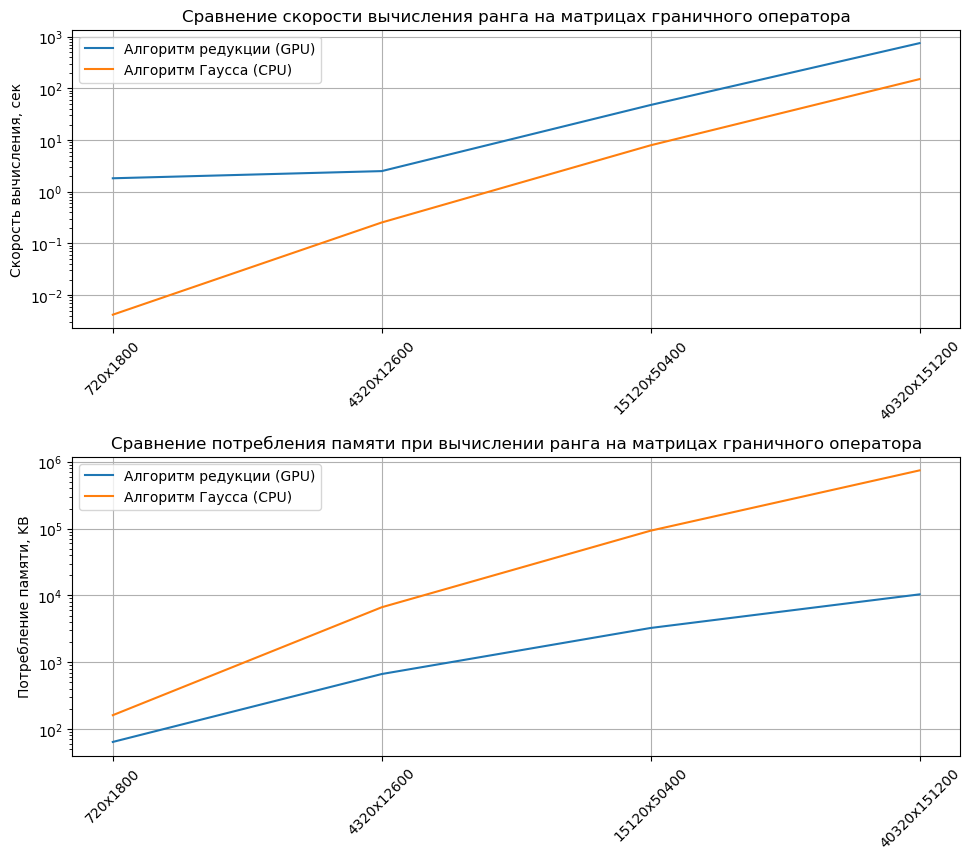

In [8]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib import pyplot as plt
import numpy as np

used_sides = [0, 1, 2, 3]
sizes = [(720, 1800), (4320, 12600), (15120, 50400), (40320, 151200)]
fig, axs = plt.subplots(2, figsize=(10, 8))

axs[0].title.set_text('Сравнение скорости вычисления ранга на матрицах граничного оператора')
axs[0].plot(used_sides, gpu_time, label="Алгоритм редукции (GPU)")
axs[0].plot(used_sides, cpu_time, label="Алгоритм Гаусса (CPU)")
axs[0].set_ylabel('Скорость вычисления, сек')

axs[1].title.set_text('Сравнение потребления памяти при вычислении ранга на матрицах граничного оператора')
axs[1].plot(used_sides, np.array(gpu_mem) // 1024, label="Алгоритм редукции (GPU)")
axs[1].plot(used_sides, np.array(cpu_mem) // 1024, label="Алгоритм Гаусса (CPU)")
axs[1].set_ylabel('Потребление памяти, KB')

plt.tight_layout(h_pad=6)

for i in range(2):
    axs[i].grid()
    axs[i].set_yscale('log')
    plt.sca(axs[i])
    plt.xticks(
        used_sides, 
        list(map(lambda x: "{}x{}".format(
            sizes[x][0], 
            sizes[x][1]
        ), used_sides)), 
        rotation=45
    )
    axs[i].legend()
    
plt.show()

In [9]:
np.save("data/homology_algo_time", gpu_time)
np.save("data/homology_algo_time_gauss", cpu_time)
np.save("data/homology_algo_mem", gpu_mem)
np.save("data/homology_algo_mem_gauss", cpu_mem)